In [1]:
# ruff: noqa: E402

#### 分析フロー
1. **データの概要把握**
2. **データ前処理**
3. **時間的要因と交通量の関係性の分析**
    - 月と交通量の関係性の分析
    - 曜日と交通量の関係性の分析
    - 時間帯と交通量の関係性の分析
4. **気象条件と交通量の関係性の分析**
    - 気温と交通量の関係性の分析
    - 天候と交通量の関係性の分析
5. **結論とまとめ**

## データを読み込んで概要を把握する

まずは、今回使用する主要ライブラリをインポートし、データセットのCSVファイルを読み込む。

Scipyの代わりにrpy2を使う理由としては、信頼区間や自由度までデフォルトで出力してくれるため中身が確認しやすく、
自分の統計レベル（統計検定2級程度）とより合っているツールだと思ったためである。

個人的な好みではあるが、データの概要をつかむ際は、複数セルに分けて出力するよりも、
1つの出力領域にまとめた方がスクロールの手間なく全体を一目で把握できて効率的に思える。
そのため、あえて繋げて1つのセルに統合している。

In [2]:
# 今回のプロジェクトに必要なライブラリをインポートする
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import rpy2.robjects as ro
from rpy2.robjects import FloatVector
from IPython.display import display

# この規模のプロジェクトでは必要ないが、将来的な拡張性と実務を見越して、
# プロジェクトルートを定義しておく
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "raw"
csv_path = DATA_DIR / "Metro_Interstate_Traffic_Volume.csv"

# CSVファイルのデータを読み込む
i_94 = pd.read_csv(csv_path)

# データの概要をつかむ

# 出力結果を見やすくするため、`print()`の代わりに、
# オブジェクトを綺麗に出力してくれる`display()`を採用
display(i_94.head())
display(i_94.tail())
display(i_94.describe())
i_94.info()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


以上のことから、次のことが分かった。

#### 【構造】

- 行: 48204, 列: 9のデータセットである
- 2012-10-02 09:00:00 から 2018-09-30 23:00:00 までのデータが揃っている
- `traffic_volume`以外の項目は、「時間」及び「気象」関連の条件である
→ EDAは、時間的要因と気象条件と交通量の関係性を分析する方向性となる
- `holiday`→ データはほぼ欠損していて使い物にならない
- `date-time`→ データは文字列なので`datetime64型`に変換する必要がある

---

#### 【外れ値】

- `temp`→ ケルビン温度なのに最小値が0となっており、異常値だと考えられる
- `rain_1h`→ 最大値が約9800mmとなっており、外れ値だと考えられる
- `traffic_volume`→ 最小値が0となっており、深夜/早朝or交通規制orデータの欠損の可能性がある（要検証）

`temp`と`rain_1h`の外れ値について、現時点ではデータ全体の傾向を把握する段階にあるため、削除は行わない。
これらの値が後の分析結果や可視化に影響を及ぼすと判明した場合には、その時点で除外または処理方法
（スケーリング調整で外れ値による描画の歪みを回避するなど）を再検討する方針とする。

※ 外れ値の判定については、各変数の統計量（特に四分位数や平均値など）を踏まえつつ、常識的に考えても明らかに極端な値を
ここでは「外れ値」と推測している。

---

##### 【分布】

`traffic_volume`
1. 平均値(3259)と中央値(3380)でズレが小さいので、歪みは小さいと考えられる
2. 標準偏差(1986)が平均値の約60%を占めており、変動がかなり大きいと考えられる

※ `traffic_volume`を目的変数とし、他の「時間」や「気象条件」を示すデータを説明変数として分析する。<br>
よって、分布に着目すべきデータは`traffic_volume`カラムのデータであることがわかる。

## データ前処理

まずは、日付データが文字列になっているので、後で混乱しないように早めに `datetime64型`に変換する。
この際、日付データは既に現地時間で集計されているため、UTCによる標準化→現地時間変換の作業は必要ない。

また、本分析の主体となる`traffic_volume`について、分布を視覚的に捉えるために、ヒストグラムを作成する。

In [3]:
# 日付データを分析（抽出やグループ化など）可能な形に変換する
i_94["date_time"] = pd.to_datetime(i_94["date_time"])

# 今回使用する時系列データを要素ごとに分解して後で分解しやすくする
i_94["date_only"] = i_94["date_time"].dt.date
i_94["hour"] = i_94["date_time"].dt.hour
i_94["day"] = i_94["date_time"].dt.day
i_94["month"] = i_94["date_time"].dt.month
i_94["year"] = i_94["date_time"].dt.year

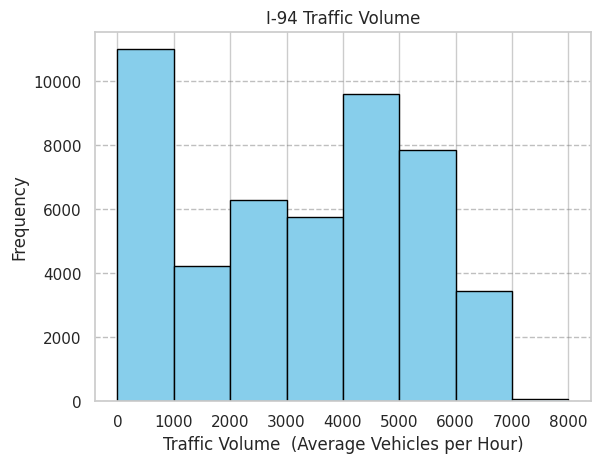

In [33]:
# 交通量の度数分布をヒストグラムで可視化する

# デフォルトだと階級幅とbin境界がズレて見にくいので、調整する
bin_width = 1000

xmin = 0
x_max = i_94["traffic_volume"].max()
bins = np.arange(xmin, x_max + bin_width, bin_width)

ax = i_94["traffic_volume"].plot.hist(bins=bins, color="skyblue", edgecolor="black")

ax.set_xticks(bins)

plt.grid(axis="y", linestyle="--", color="gray", alpha=0.5)
plt.title("I-94 Traffic Volume")
plt.xlabel("Traffic Volume  (Average Vehicles per Hour)")
plt.ylabel("Frequency")
plt.show()

`traffic_volume`のヒストグラムの結果から、二峰性が伺える。

0～1000台と4000～5000台の階級で度数が特に増えていることから、
「交通量が増えるラッシュアワー」と「交通量が減る閑静期」の2つの分布が混ざっている可能性を疑う。

`traffic_volume`と他の説明変数との相関係数を確認して、まずはどの要因が交通量に影響を与えているのかを調べていく。

In [5]:
i_94.corr(numeric_only=True)["traffic_volume"].sort_values(ascending=False)

traffic_volume    1.000000
hour              0.352401
temp              0.130299
clouds_all        0.067054
year              0.004753
rain_1h           0.004714
snow_1h           0.000733
month            -0.002533
day              -0.007587
Name: traffic_volume, dtype: float64

データセットのうち、量的なデータを扱うコラムの中では`traffic_volume`と相関がありそうなのは`hour`だということがわかった。

次に、一番交通量と相関が強そうな日付データの`hour`項目について分析していく。
最初のステップとして「時間帯によって交通量が変動する」のであれば、「日中」と「夜間」での交通量の分布の違いを確認する。

### 日中と夜間の交通量の分布比較

両者の分布を知るにあたって、前処理として`i_94`データセットを2つの時間帯「日中」と「夜間」のデータセットに分割していく。
そのあと、作成した2つのヒストグラムを比較対照する。

In [6]:
# 日中データと夜間データに分割
# 元データ`i_94`に不本意な影響を及ぼさないよう、`copy()`をつかう
day_time = i_94[(i_94["hour"] >= 6) & (i_94["hour"] <= 18)].copy()
night_time = i_94[(i_94["hour"] > 18) | (i_94["hour"] < 6)].copy()

# 正しく元データを二つに分割できてるか確認（確認作業1）
print(day_time.shape)
print(night_time.shape)

(25964, 14)
(22240, 14)


In [7]:
# 2つのデータの行和が元データの行総数に照合するかを確認
# → `True`と出力されればOK（確認作業2）
day_time.shape[0] + night_time.shape[0] == len(i_94)

True

二つの確認作業によって、データが正しく分割されていることが確認できたので、
早速両者の分布をヒストグラムで可視化して比較対照していく。

Text(0, 0.5, 'Frequency')

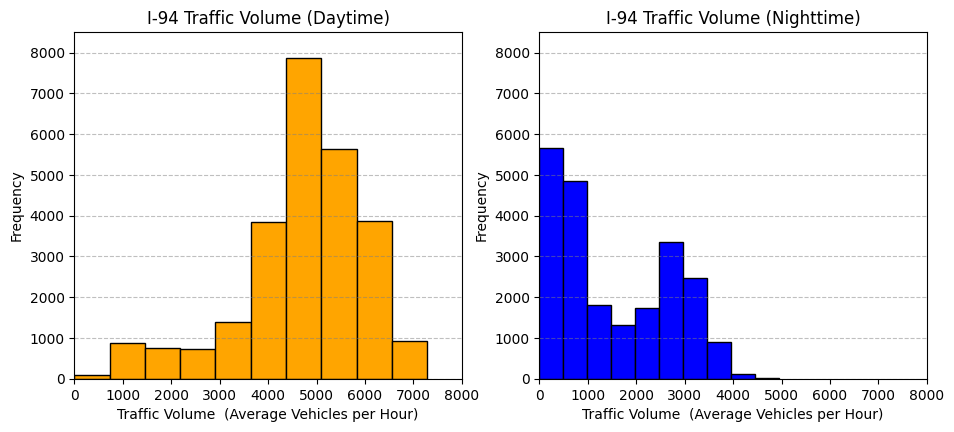

In [8]:
# 新たに作成した「日中データ」と「夜間データ」の度数分布をヒストグラムで可視化

# 全体のキャンバスを作成
plt.figure(figsize=(11, 4.5))

# 日中データについての描画
plt.subplot(1, 2, 1)
plt.hist(day_time["traffic_volume"], color="orange", edgecolor="black")
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.5)
plt.xlim(0, 8000)
plt.ylim(0, 8500)
plt.title("I-94 Traffic Volume (Daytime)")
plt.xlabel("Traffic Volume  (Average Vehicles per Hour)")
plt.ylabel("Frequency")

# 夜間データについての描画
plt.subplot(1, 2, 2)
plt.hist(night_time["traffic_volume"], color="blue", edgecolor="black")
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.5)
plt.xlim(0, 8000)
plt.ylim(0, 8500)
plt.title("I-94 Traffic Volume (Nighttime)")
plt.xlabel("Traffic Volume  (Average Vehicles per Hour)")
plt.ylabel("Frequency")

- 日中の交通量の分布は左裾が伸びている
- 夜間の交通量の分布は右裾が伸びている

→ 両者の分布形状から、同一性は否定される。したがって、「日中」と「夜間」では交通量の分布に有意な差があると考えられる。
ただし、ヒストグラムで把握できるのは分布の大まかな傾向にとどまるため、より精緻に確認するために統計量も併せて検討する。

In [9]:
# 統計量の対称比較がしやすいように、横並びレイアウトとなるような要約表を
# 'pd.DataFrame()'で作成
summary = pd.DataFrame(
    {
        "Daytime": day_time["traffic_volume"].describe(),
        "Nighttime": night_time["traffic_volume"].describe(),
    }
)

print("Traffic Volume")
display(summary)

Traffic Volume


,Daytime,Nighttime
count,25964.000000,22240.000000
mean,4712.087429,1564.372572
std,1281.625783,1140.970036
min,0.000000,0.000000
25%,4232.000000,484.000000
50%,4849.500000,1117.000000
75%,5597.000000,2693.000000
max,7280.000000,4939.000000


日中の方が交通量が多いことが明示された。<br>
今回の分析目的は「交通量の多い時間帯を見つける事」なので、<br>
これからは日中の交通量データに絞って、更なる要因の発見に努めていく。

## 交通量と時間的要因

これより、交通量との相関が示唆された「時間的要因」についてさらなる深堀を行っていく。

### 月と交通量の関係

まずは、季節変動を掴むために、月ごとの交通量の平均を求めて折れ線グラフで表示する。

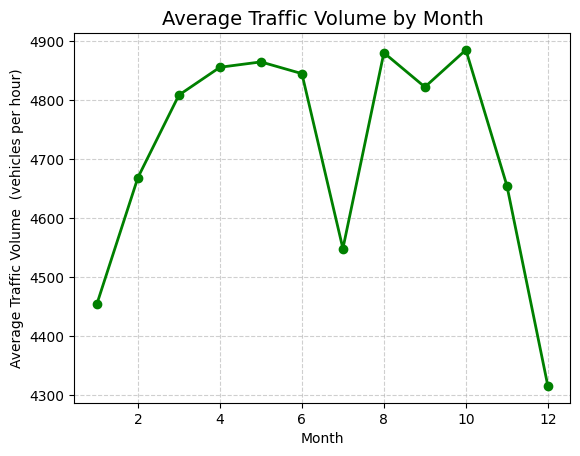

In [10]:

# 日中データに限って、全年度を通した月ごとの平均交通量を計算
by_month = day_time.groupby("month")["traffic_volume"].mean().sort_index()
# グラフを描画
by_month.plot(marker="o", color="green", linewidth=2)
plt.title(r"Average Traffic Volume by Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Traffic Volume  (vehicles per hour)")
plt.grid(True, linestyle="--", alpha=0.6)

春から秋にかけて交通量がピークを迎え、冬の間交通量が急降下してボトムとなる周期性を捉えることができた。
今回の分析目的は「交通量の多いゴールデンタイム」を特定することなので、特に交通量の多い春～秋の時期に今後はフォーカスしていく。

しかし、その前に７月頃に発生した不自然な急降下についても調べたい。

この原因を知ることによって、交通量の多い時期の中でも地雷となる期間を避けてキャンペーンを施行できるようになるかもしれないし、
最初に明らかになった謎の「交通量最小値: 0」の真相を掴めるかもしれないからだ。

#### 不振な推移（7月の交通量の急降下）の原因究明

これから、「暖かい時期に交通量が増えるという周期性がある」という仮説に矛盾する、7月における交通量の不自然な減少について
調べていく。まずは、異常値の影響の有無を確認するために、IQRを用いて外れ値を除外した後の月ごとの平均交通量を計算し、
元の月ごとの平均交通量と比較する。

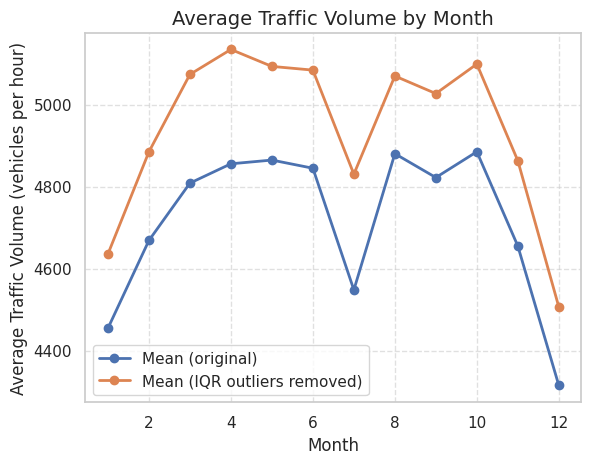

In [34]:


def remove_outliers_iqr(group, col="traffic_volume", k=1.5):
    q1 = group[col].quantile(0.25)
    q3 = group[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    # month を確実に保持（include_groups=False 対応）
    return group[(group[col] >= lower) & (group[col] <= upper)].assign(month=group.name)


day_time_clean = day_time.dropna(subset=["month", "traffic_volume"]).copy()

day_time_no_out = day_time_clean.groupby("month", group_keys=False).apply(
    remove_outliers_iqr, include_groups=False
)

by_month_iqr = day_time_no_out.groupby("month")["traffic_volume"].mean().sort_index()
by_month = day_time.groupby("month")["traffic_volume"].mean().sort_index()

ax = by_month.plot(marker="o", linewidth=2, label="Mean (original)")
by_month_iqr.plot(ax=ax, marker="o", linewidth=2, label="Mean (IQR outliers removed)")

plt.title("Average Traffic Volume by Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Traffic Volume (vehicles per hour)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

外れ値を除外した月ごとの平均交通量は、オリジナルに比べて全体的に上昇しているが、大まかなパターンは変わっていない。
外れ値の影響を受けやすいオリジナルのデータの方が全体的に低い値をとっていることから、外れ値は「データの欠損系」である
可能性が考えられる。しかし、どちらの場合であっても、依然として7月に不自然な急降下が発生していることに変わりはない。

次に、
各年の七月についての交通量をまとめたグラフを作成し、より具体的に「いつ頃にこの不自然な急降下が発生したのか」を調べていく。

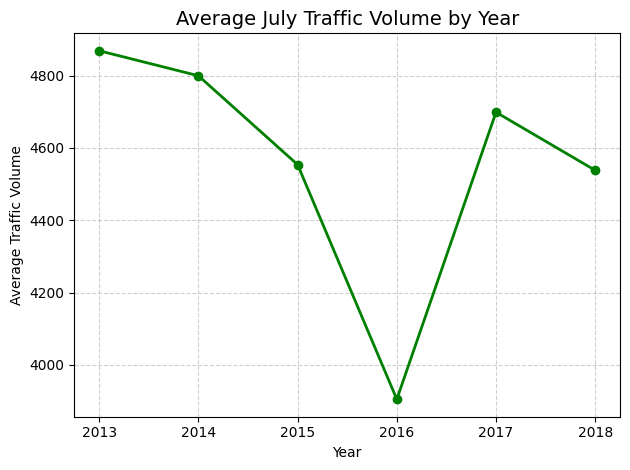

In [12]:
# 7月の交通量を年ごとに平均して可視化する（日中データ）
by_year_july = (
    day_time.query("month == 7")  # 日中データにおいて、7月だけ抽出
    .groupby("year")["traffic_volume"]  # 年ごとに交通量をグループ化
    .mean()  # 各年の平均交通量の平均を計算（平均の平均）
    .sort_index()
)

# グラフ描画
by_year_july.plot(marker="o", color="green", linewidth=2)
plt.title("Average July Traffic Volume by Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Traffic Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

どうやら、2016年の7月におけるなんらかの原因で、7月全体の交通量が下がっていたという可能性が見えてきた。

そのため、これから2016年の7月の何日にそれが起こったのかを調べてみる。

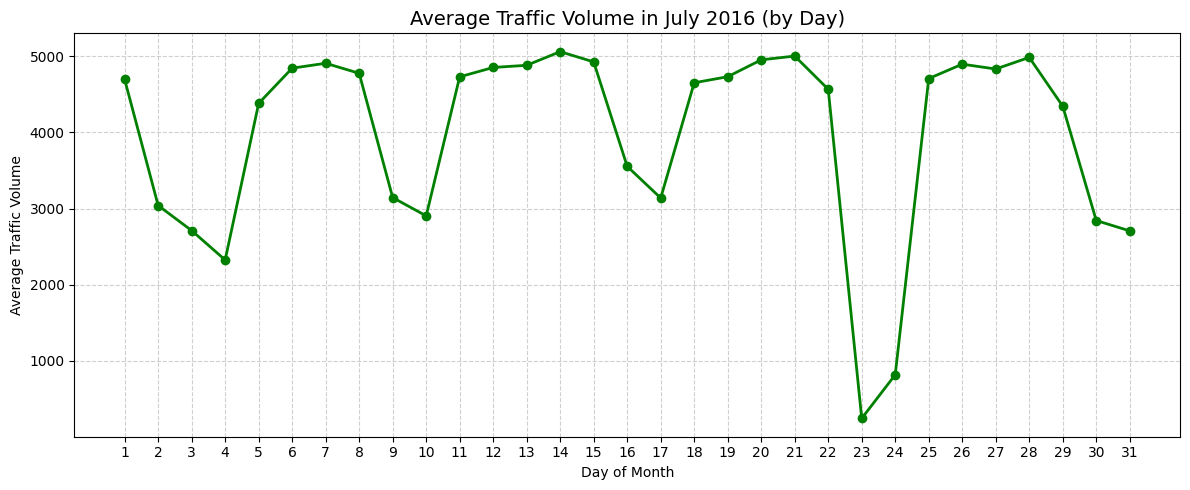

In [13]:

# 2016年7月に限定した日ごとの平均交通量を計算
by_day_2016_july = (
    day_time.query("year == 2016 and month == 7")  # 2016年において7月だけ抽出
    .groupby("day")["traffic_volume"]  # 日単位でグループ化
    .mean()  # 各日の平均を計算
)

# グラフを描画
plt.figure(figsize=(12, 5))
by_day_2016_july.plot(marker="o", color="green", linewidth=2)
plt.title("Average Traffic Volume in July 2016 (by Day)", fontsize=14)
plt.xlabel("Day of Month")
plt.ylabel("Average Traffic Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(range(1, 32))  # X軸の目盛りを1日ごとに設定
plt.tight_layout()
plt.show()

この結果から、2016年における7月の不自然な交通量の急行落は、23日から24日にかけてのデータに強い影響を受けていることがわかる。

また、ウェブリサーチの結果、以下の2つのことが分かった。
- 4日→独立記念日（祝日）による交通量減少の可能性<sup><a href="#fn1" id="ref1" style="color: red;">1</a></sup>
- 9,10日→大規模な抗議活動による閉鎖発生による影響の可能性<sup><a href="#fn2" id="ref2" style="color: red;">2</a></sup>
<br>

このようなイベント発生日よりも交通量が大幅に下がっていることを考慮すると、俄然23日~24日の交通量は不自然であるように思える。
この時点で、外れ値であることは自明である。
<br><br>
<hr>

<p id="fn1">
  <a href="#ref1" style="color: red;">1.</a>
  <a href="https://content.govdelivery.com/accounts/USDHSCBP/bulletins/12baf00#:~:text=05%20PM%20EST-,Air%20Manifest,Monday%2C%20December%2026%20Christmas%20Day">2016年の連邦祝日</a>のウェブページを参照(最終アクセス日: 2025年12月11日)
</p>

<p id="fn2">
  <a href="#ref2" style="color: red;">2.</a>
  <a href="https://www.twincities.com/2016/07/15/how-the-i-94-takeover-became-a-full-scale-riot/">
PIONEER PRESSのニュース記事</a>を参照(最終アクセス日: 2025年12月11日)
</p>

そこで今度は、より詳細なグラスプを得るために、当年の7月22~27日のデータについて比較対照を行っていく。
日数の選定基準としては、目算で正常なデータと異常なデータを視覚的に捉えられる範囲を適当に決定した。

今回の可視化では、グラフの不振な動きを見逃さずに全体的な推移を捉えられるよう、
`day_time`（日中データ）ではなく`i_94`（全日データ）で比較する。

<Figure size 1200x500 with 0 Axes>

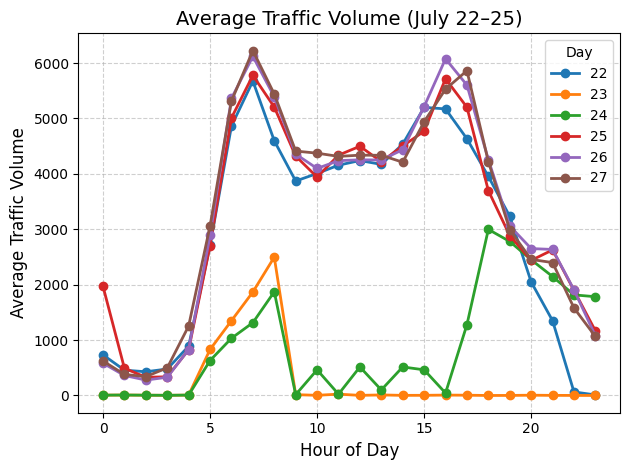

In [14]:
# 7月22〜25日のデータを抽出して、時間ごとの平均を算出
by_hour_july_22_25 = (
    i_94.query(
        "year == 2016 and month == 7 and day in [22,23,24,25,26,27]"
    )  # 該当の時系列データを抽出
    .groupby(["day", "hour"])["traffic_volume"]  # 日別と時間別でグループ化
    .mean()  # 上のグループごとに平均交通量の平均を計算
    .unstack("day")  # 各日を比較できるように行から列に展開
)

# グラフ描画
plt.figure(figsize=(12, 5))
by_hour_july_22_25.plot(marker="o", linewidth=2)
plt.title("Average Traffic Volume (July 22–25)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Traffic Volume", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Day")
plt.tight_layout()
plt.show()

23日と24日は他の日と比べて不自然な推移をしているため、臨時的な交通止めもしくはデータの欠損の可能性が考えられる。
とくに、23日の外れ値に関しては、22日の23:00頃から24日の4:00まで続き、その余韻ともとれる不審な変動が同日の16:00まで続いている。

どちらにせよ、この急降下は偶発的な要因によるものと予想され、現時点では特定の時間帯との因果は見られない。
もしかすると気象条件と交通量の相関調査で、この不自然な推移について新たに明らかになることがあるかもしれないため、
この外れ値はまだデータセットから削除せず、そのまま分析を続行していく（頭の片隅にこの外れ値のことは常においとく）。

それでは、7月の不審な推移の調査に一段落が付いたところで、本プロジェクトの主目的「いつ交通量が最も多くなるのか」に舵を戻す。

### 曜日と交通量の関係

現時点で、「月（季節）と交通量の関係」がわかっているので、次のステップとして、「曜日と交通量の関係性」について調べていく。

曜日は7項目（月～日）あるので、同一のキャンバスに描くとぐちゃぐちゃして見にくい。かといってすべて異なるキャンバスに描いても
比較対照しずらい。
解決策としては、曜日の中でも「平日」「週末」に分割して、それぞれの平均を算出して比較することだが、個人的には最初は全体像を
つかみたいので、結局一つのキャンバスに全ての曜日を表示させる方針でいく。

しかし、すこしでも比較しやすくするために、各曜日の平均交通量は移動平均で平滑化し、更に凡例を平均交通量が多い順で
表示することで、全体像をつかみながらも、各曜日の交通量との関係も捉えられるようにする。

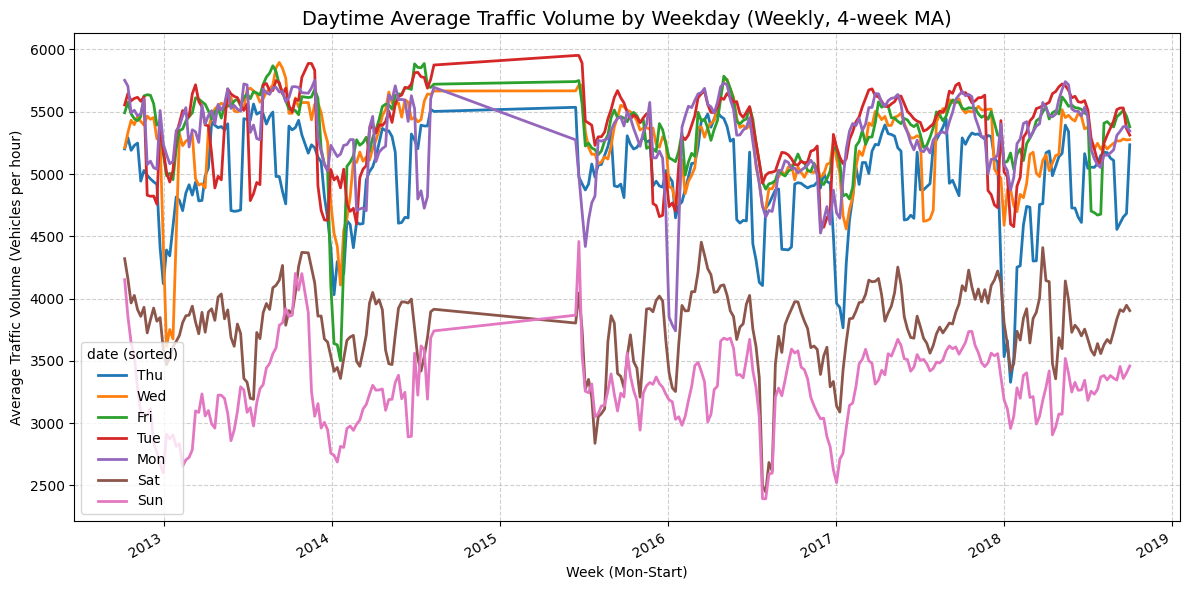

In [15]:

by_week_weekday = (
    day_time.groupby(
        [
            pd.Grouper(
                key="date_time", freq="W-MON"
            ),  # 月曜日を始点として、各週（月～金）ごとにグループ化
            day_time[
                "date_time"
            ].dt.dayofweek,  # 各データの曜日（0=Mon,...,6=Sun）を取得
        ]
    )[
        "traffic_volume"
    ]  # '各週 × 曜日ごと'に平均交通量の平均を算出
    .mean()  # '曜日'を行から列に展開
    .unstack()
    .rename(
        columns={0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
    )  # 曜日を数字から英語表記に変換
    .sort_index()  # 正しい時間軸に並べ替え
)

# 複数の時系列データを比較対照したいため、見やすいように平滑化する（4週移動平均で算出）
by_week_weekday_MA = by_week_weekday.rolling(window=4, min_periods=1).mean()


# 各曜日の平均交通量を算出して、降順に並べる
weekday_order = by_week_weekday_MA.mean().sort_values(ascending=False).index.tolist()
# グラフを描画
ax = by_week_weekday_MA.plot(figsize=(12, 6), linewidth=2)

# 凡例を、降順の曜日順で表示
ax.legend(title="date (sorted)", labels=weekday_order)

# タイトルなどはそのまま
ax.set_title(
    "Daytime Average Traffic Volume by Weekday (Weekly, 4-week MA)", fontsize=14
)
ax.set_xlabel("Week")
ax.set_ylabel("Average Traffic Volume (Vehicles per hour)")
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

この結果から、交通量に関して、平日＞土日の傾向があること、木曜・水曜・金曜の順番で交通量が多いことを確認できた。
しかし、懸念した通りグラフが直感的に捉えずらく、特に交通量の分布が拮抗している平日の中で「どの曜日が一番交通量が
多いのか」が依然としてわからない。よって、このグラフを簡易化し、曜日ごとに平均を算出したものプロットする必要がありそうだ。

ただ、全体像を表示したことによって、またもやデータの不審な動きをとらえることができた。2014年の夏ごろから2015年の夏ごろに
かけて、データが全く変動していない。

原因としてはこの間のデータの欠損が予想されるが、念のために、この現象の原因究明を試みる。

#### 変動しないデータの正体

既知の情報として、2014年と2015年に変動しないデータが存在していることがわかっている。<br>
未知の情報としては月と曜日なので、それを特定できるように、「○ 月の平均交通量の推移」がわかるコード<br>

```python
by_day_「年を代入」_「月を代入」 = (
    day_time.loc[
        (day_time['year'] == 「年を代入」) & (day_time['month'] == 「月を代入」 )
    ]
    .groupby('day')['traffic_volume']
    .mean()
)
```


を2つ作り、`「月を代入」`のところに順次月を代入していき、グラフの出力結果を基に異常が発生した期間を特定する
原始的な方法をとる。

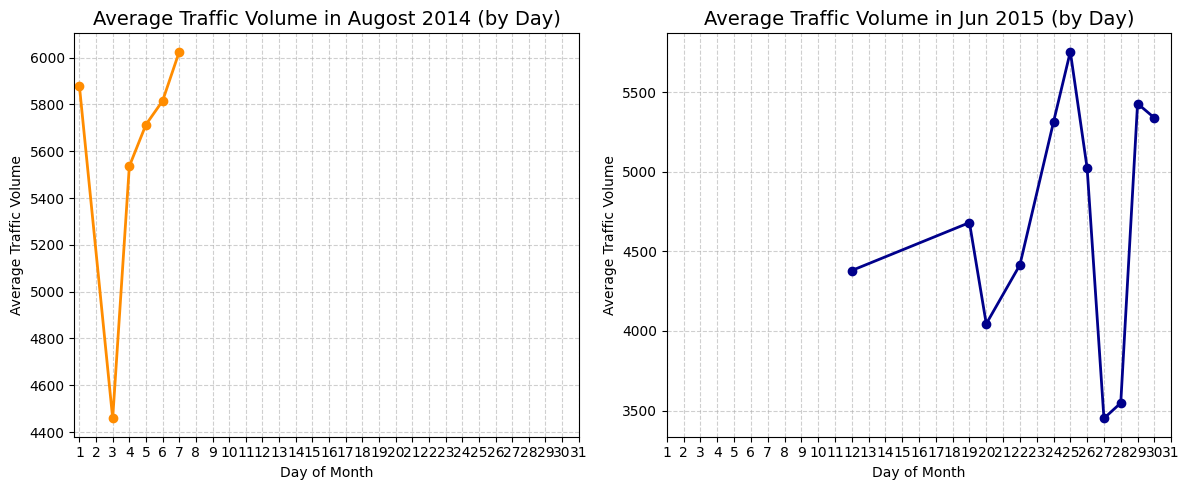

In [16]:
# 2016年7月に限定した日ごとの平均交通量を計算
by_day_2014_august = (
    day_time.loc[
        (day_time["year"] == 2014) & (day_time["month"] == 8)
    ]  # 2016年7月だけ抽出
    .groupby("day")["traffic_volume"]  # 日単位でグループ化
    .mean()  # 各日の平均を計算
)


# 2015年7月に限定した日ごとの平均交通量を計算
by_day_2015_july = (
    day_time.loc[
        (day_time["year"] == 2015) & (day_time["month"] == 6)
    ]  # 2015年6月だけ抽出
    .groupby("day")["traffic_volume"]  # 日単位でグループ化
    .mean()  # 各日の平均を計算
)

# グラフを描画
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
by_day_2014_august.plot(marker="o", color="darkorange", linewidth=2)
plt.title("Average Traffic Volume in Augost 2014 (by Day)", fontsize=14)
plt.xlabel("Day of Month")
plt.ylabel("Average Traffic Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(range(1, 32))  # X軸の目盛りを1日ごとに設定
plt.tight_layout()

plt.subplot(1, 2, 2)
by_day_2015_july.plot(marker="o", color="darkblue", linewidth=2)
plt.title("Average Traffic Volume in Jun 2015 (by Day)", fontsize=14)
plt.xlabel("Day of Month")
plt.ylabel("Average Traffic Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(range(1, 32))  # X軸の目盛りを1日ごとに設定
plt.tight_layout()

分析の結果、2014年8月7日〜2015年6月12日の期間にかけて継続的な欠損があることが分かった。
よって、セル［15］の移動平均グラフで見られた「一定値が続くフラットな区間」は、この欠損によるものである可能性が高い。

本プロジェクトでは、この欠損値に対して積極的な補完や削除は行わないこととした。
理由は以下の通りである。

* 本プロジェクトで扱う日付データのサンプルサイズは十分に大きい。
* 欠損が発生している期間は、特定の月や曜日に偏っておらず、交通量の季節性・曜日性の傾向を大きく歪める可能性は低いと判断される。

以上から、現時点では分析結果への影響は限定的とみなし、EDAフェーズにおいては欠損値をそのまま許容する。

なお、より厳密なモデル構築や予測を目的とした分析であれば、
このような欠損期間については、適切な補完や除外ルールを設けて処理する必要がある。

### 曜日と交通量の関係
気を取り直して、曜日ごとの平均交通量をプロットしたグラフを作成し、「結局どの曜日に一番交通量が多くなるのか」
という問いに答えていく。
セル［13］のグラフの結果から、平日の平均交通量は値が拮抗していることがわかっているため、平均交通量が最大値を記録する地点を
赤色のマーカーで強調表示し、「最多平均交通量をもつ曜日」が直感的にすぐ判別できるようなグラフを作成する。

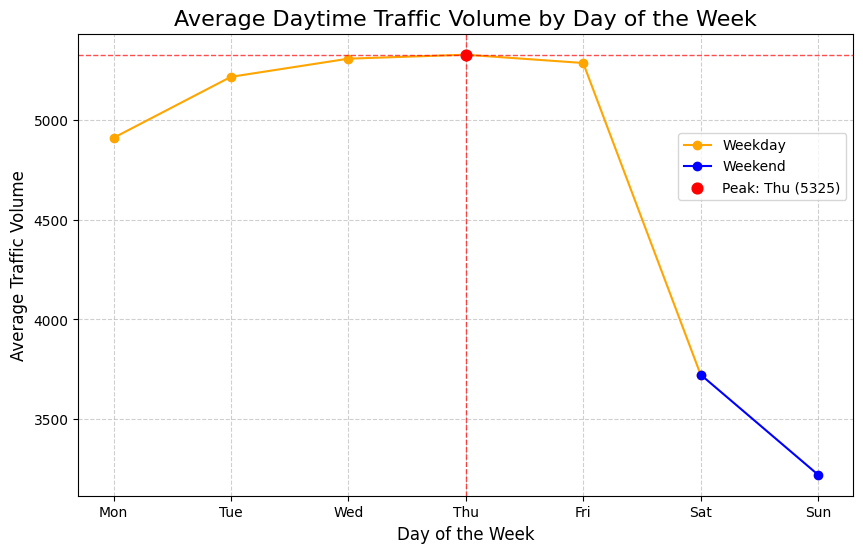

In [17]:
# 曜日ごとの平均交通量を算出して、最も交通量が多い曜日を強調表示するグラフを描く

# 曜日ごとの比較を可能にするため、日付データから'曜日情報（0=Mon,...,6=Sun）'を取得
day_time["dayofweek"] = day_time["date_time"].dt.dayofweek

# `traffic_volume`以外の文字列データを含むカラムもグループ化してしまっているので、
# 平均を算出する際に`numeric_only=True`とする
by_dayofweek = day_time.groupby("dayofweek").mean(numeric_only=True)

# ↑で取得した'曜日情報'を、数字表記（0~6）から英語表記（Mon~Sun）に変換
day_mapping = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
by_dayofweek.rename(index=day_mapping, inplace=True)


max_volume = by_dayofweek["traffic_volume"].max()  # 曜日単位おける交通量の最大値を取得
max_day = by_dayofweek["traffic_volume"].idxmax()  # ↑の最大値を持つ曜日名を取得

# グラフの描画
plt.figure(figsize=(10, 6))
plt.plot(
    by_dayofweek.loc["Mon":"Sat", "traffic_volume"],
    marker="o",
    color="orange",
    label="Weekday",
)
plt.plot(
    by_dayofweek.loc["Sat":"Sun", "traffic_volume"],
    marker="o",
    color="blue",
    label="Weekend",
)

plt.scatter(
    x=max_day,
    y=max_volume,
    color="red",
    s=60,
    zorder=3,  # 最大値を明示しつつ赤点マーカーで表示
    label=f"Peak: {max_day} ({max_volume:.0f})",
)
plt.axvline(
    x=max_day, color="red", linestyle="--", linewidth=1, alpha=0.7
)  # 赤点で交わる罫線を追加し見やすくする
plt.axhline(y=max_volume, color="red", linestyle="--", linewidth=1, alpha=0.7)

plt.title("Average Daytime Traffic Volume by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Traffic Volume", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)

plt.legend(loc="upper right", bbox_to_anchor=(1, 0.8))

plt.show()

このグラフから、木曜日が最も交通量が多い曜日であり、金曜日と水曜日がそれに僅差で続いていることがわかった。
また、平日の中でも、月曜日がもっとも交通量が少ない曜日であることもわかった。

この結果から、ビルボード広告のキャンペーンを実施するならば、平日の中でも、月曜日の実施に割くコストを減らし、
木曜日・金曜日・水曜日の順番で優先的に予算を割くことが効果的であると考えられる。

### 時間帯と交通量の関係

次は、一日の中でも特に交通量が多い時間帯を特定するために、時間帯ごとの平均交通量を比較していく。
このグラフでも同様に、ピーク時を赤点で強調表示し、直感的に把握しやすいようにする。

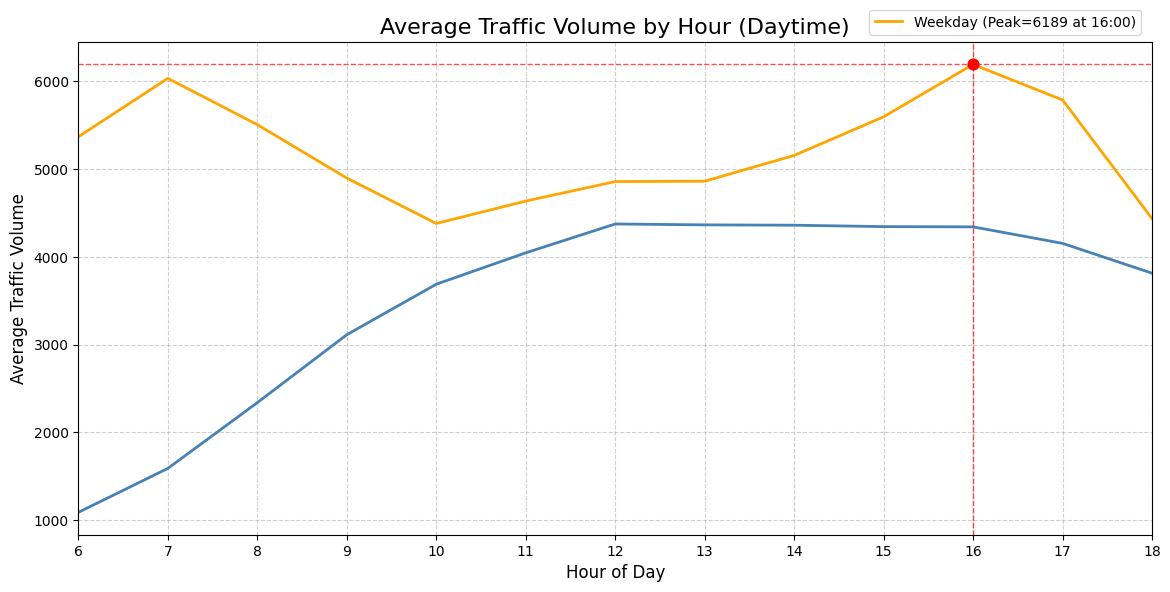

In [18]:
# 平日・週末それぞれの時間帯ごとの平均交通量を比較し、ピークを可視化

# 平日・週末でデータを分割
business_days = day_time[day_time["dayofweek"] <= 4].copy()
weekend = day_time[day_time["dayofweek"] >= 5].copy()

# 平日の平均交通量を算出
by_hour_business = business_days.groupby("hour").mean(numeric_only=True)
by_hour_weekend = weekend.groupby("hour").mean(numeric_only=True)

# 各グループのピーク時（最大値）を取得
peak_hour_business = by_hour_business["traffic_volume"].idxmax()
peak_value_business = by_hour_business["traffic_volume"].max()


# グラフを描画
plt.figure(figsize=(12, 6))

# 平日・週末の折れ線グラフ
plt.plot(
    by_hour_business.index,
    by_hour_business["traffic_volume"],
    label=f"Weekday (Peak={peak_value_business:.0f} at {peak_hour_business}:00)",
    color="orange",
    linewidth=2,
)
plt.plot(
    by_hour_weekend.index,
    by_hour_weekend["traffic_volume"],
    color="steelblue",
    linewidth=2,
)

# 平日のピークを赤点と破線で強調
plt.scatter(peak_hour_business, peak_value_business, color="red", s=60, zorder=3)
plt.axvline(x=peak_hour_business, color="red", linestyle="--", linewidth=1, alpha=0.7)
plt.axhline(y=peak_value_business, color="red", linestyle="--", linewidth=1, alpha=0.7)


# 軸・タイトル
plt.title("Average Traffic Volume by Hour (Daytime)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Traffic Volume", fontsize=12)

plt.xlim(6, 17)
plt.xticks(ticks=range(6, 19))
plt.legend(loc="upper left", bbox_to_anchor=(0.73, 1.08))
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

このグラフから、平日の交通量は朝の6時から7時、また夕方の3時から5時にかけてラッシュアワーを迎え、
午後4時ごろにピークを迎えることがわかった。

一方で、先ほどのグラフでも示唆された通り、週末の交通量は平日に比べて全体的に低く、やはり広告効果を最大化するためには
平日にキャンペーンを実施することが望ましいと考えられる。

### 時間的要因の分析結果まとめ

これまでの時間的要因について分析した結果をまとめると、次のようなことが分かった。

- 寒い季節に比べ、暖かい季節の方が交通量が多い傾向にある
- 週末に比べ、平日の方が交通量が多い傾向にある
- 平日については朝の6時から7時、また、夕方の3時から5時がラッシュアワー（午後4時ごろが最大）であり、
僅差で水・木・金の交通量が多い（木曜日が最大）。

## 交通量と気象条件

これまでは、`date_time`に関して、交通量がピークを迎える傾向にある条件を特定した。<br>
これからは、これからは気象条件を軸に交通量との関係性を分析していく。

セル［4］で出力したデータセットの定量データにおける交通量との相関係数のうち、`temp`は約0.1と交通量との相関は弱いが、
量的データにおける気象条件カテゴリの中ではトップの項目なので、念のために可視化してみる。
応量的データにおける気象条件カテゴリの中ではトップの項目だったので、可視化してみる。

応答変数の`traffic_volume`をy軸に、説明変数の`temp`をx軸において、散布図を作成する。

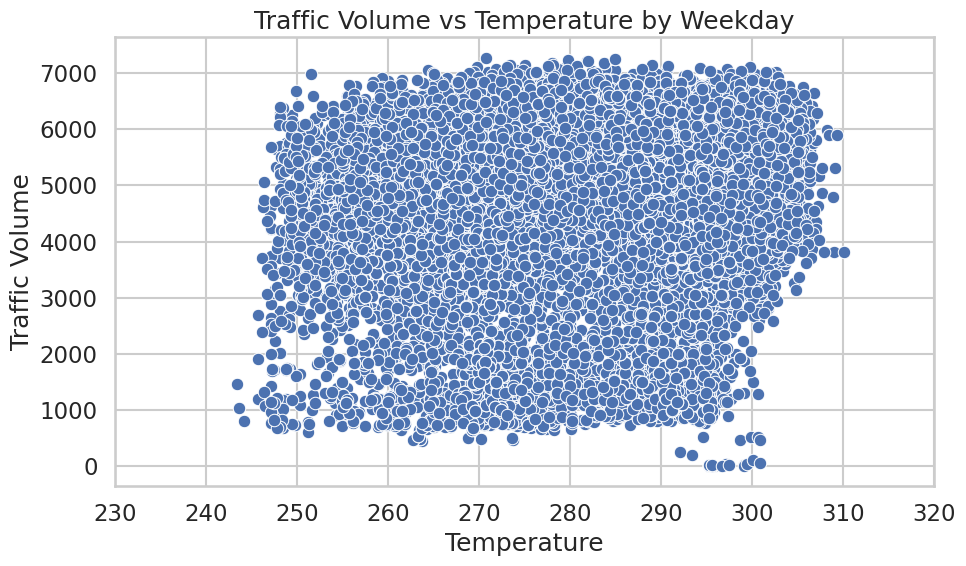

In [19]:
# --- グラフの描画 ---
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(data=day_time, x="temp", y="traffic_volume")

plt.title("Traffic Volume vs Temperature by Weekday")
plt.xlabel("Temperature")
plt.ylabel("Traffic Volume")
# 気温データにはケルビン0℃（絶対零度）が含まれているので、調整した範囲を設定
plt.xlim(230, 320)
plt.tight_layout()
plt.show()

やはり交通量と気温（ケルビン温度）の間に相関は見られない。

よって、これにて量的データをあつかうカラムに関する分析は終了し、質的データを扱うカラムについての分析に移行する。

気象条件に関して、質的データを扱うカラムは二つある。

- `wheather_main`: 天気の種類（大まかな分類）
- `weather_description`: 天気の詳細説明

よって、まずは天気の種類と交通量の関係性をグラフで視覚化していく。

今回は天気の種類（カテゴリカルデータ）の度数を把握したいので、ヒストグラムではなく棒グラフを用いる。
それをなるべく見やすいように度数の多い順に並べ替え、かつ最大値が一目でわかるように対応するバーの色を変え、
具体的な値も表示する。

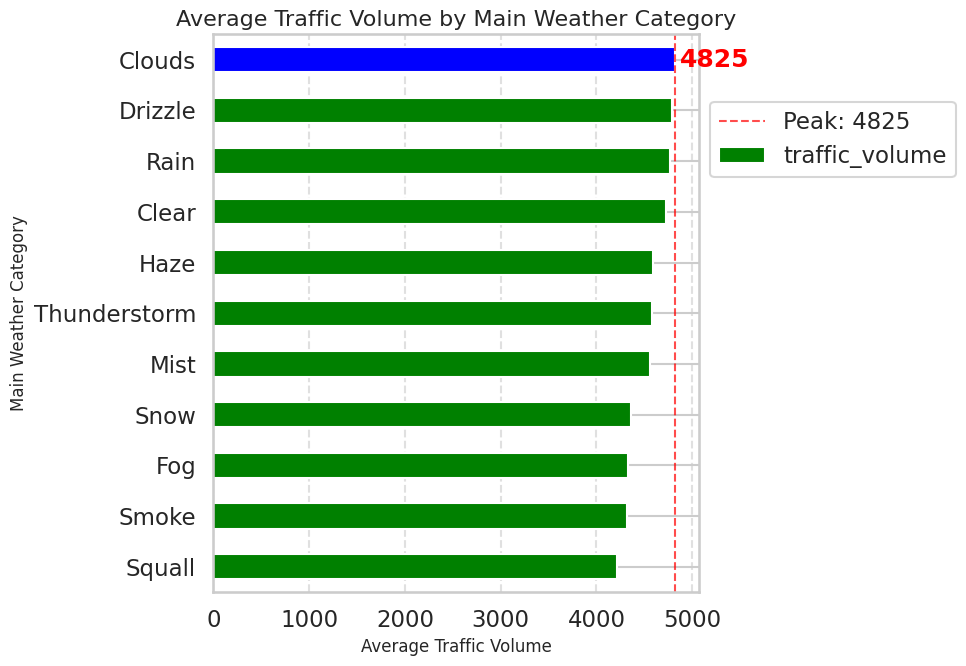

In [20]:

# 天気の種類（例：Clear、Rain、Snowなど）ごとに平均交通量を比較し、
# 最も交通量が多い天気を強調表示する棒グラフを作成


# `weather_main`列における平均交通量を計算し、値の小さい順に取得
by_weather_main = (
    day_time.groupby("weather_main")["traffic_volume"].mean().sort_values()
)

# ↑ で取得したもののうち、最大のものを取得し、その曜日情報を取得する
max_volume_main = by_weather_main.max()
max_weather_main = by_weather_main.idxmax()


# グラフを描画
plt.figure(figsize=(10, 7))

# 【見やすい設定】
colors = [
    "blue" if weather == max_weather_main else "green"
    for weather in by_weather_main.index
]
by_weather_main.plot.barh(
    color=colors
)  # 横棒に関して、ピーク値のものを青、それ以外を緑色で表示

plt.axvline(
    x=max_volume_main,
    color="red",
    linestyle="--",
    linewidth=1.5,
    alpha=0.7,
    label=f"Peak: {max_volume_main:.0f}",
)  # ピーク値に対応するタテの罫線を追加し見やすくする

y_labels = by_weather_main.index.to_list()
max_weather_position = y_labels.index(max_weather_main)
plt.text(
    max_volume_main + 50,
    max_weather_position,
    f"{max_volume_main:.0f}",
    va="center",
    color="red",
    fontweight="bold",
)  # 天気カテゴリの中で、最大値に対応する横棒のヨコに数字を強調して描画


plt.title("Average Traffic Volume by Main Weather Category", fontsize=16)
plt.xlabel("Average Traffic Volume", fontsize=12)
plt.ylabel("Main Weather Category", fontsize=12)
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.90))
plt.tight_layout()
plt.show()

この結果からは、天気の種類と交通量との間に特別な関係性は示唆されない。

しかし、ヒストグラムでbin設定（階級の幅）が大きすぎると細かい分布の凹凸がならされてしまい、
のっぺりとした山になってデータの特徴を見逃してしまうのと同じような現象が起こっている可能性もあるので、
ここで天気と交通量の間に相関や因果関係が成り立たないと結論づけるのは早計である。

なので、次に、今回分析した`wheather_main`よりも粒度の高い`wheather_description`についても、
同じ要領で棒グラフを作成し度数を再比較してみる。

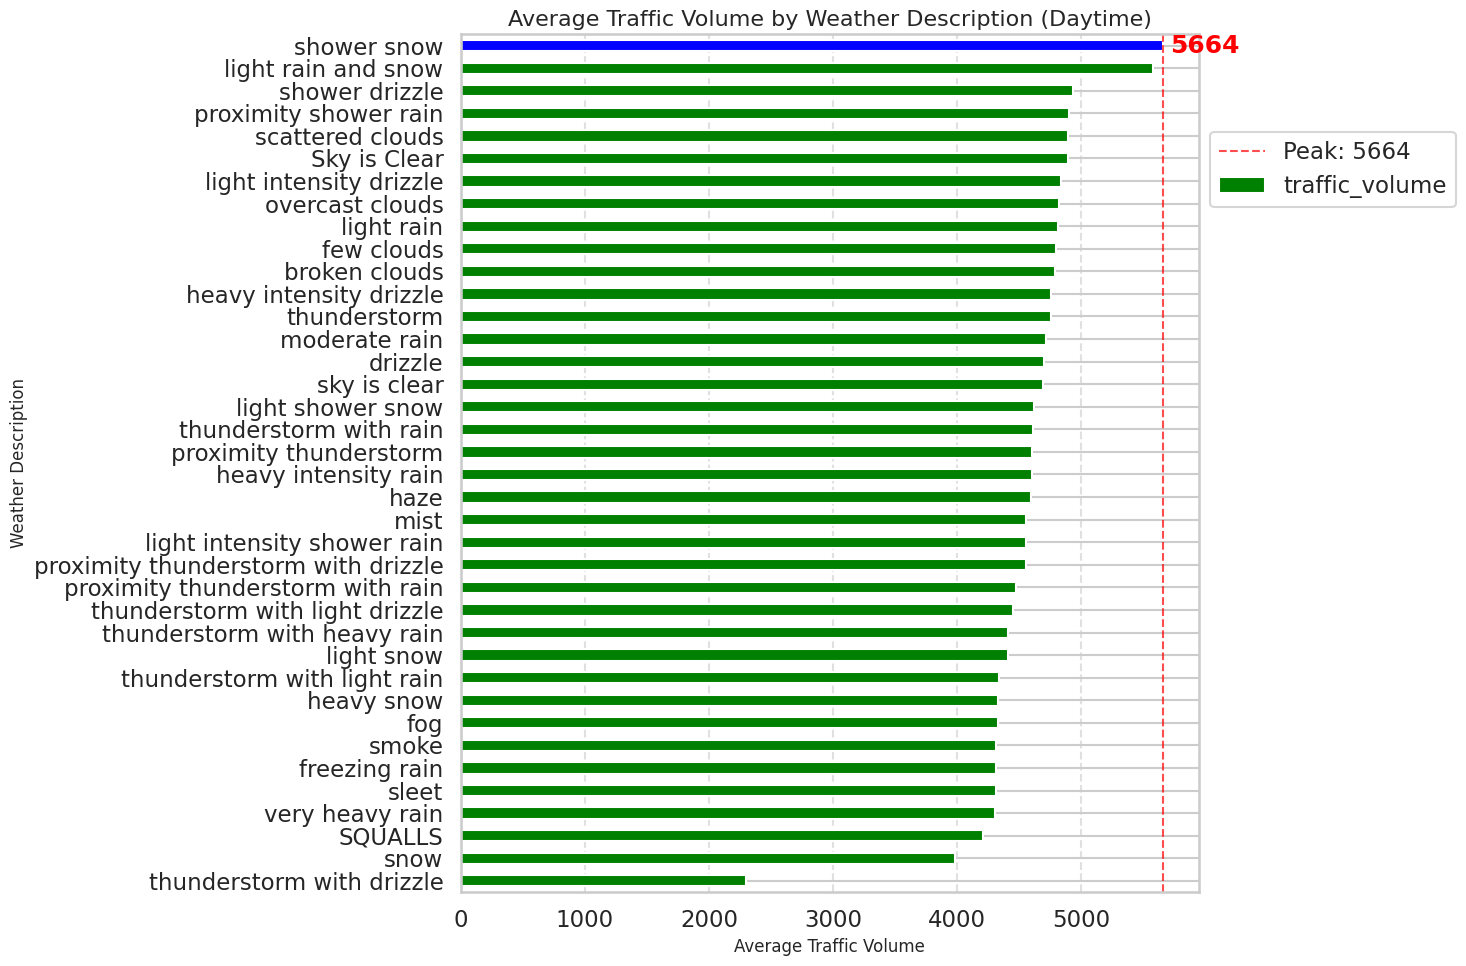

In [21]:

# 天気の詳細説明ごとに平均交通量を比較し、最も交通量が多い気象条件を強調するグラフを作成


# `weather_description`列における平均交通量を計算し、値の小さい順に取得
by_weather_description = (
    day_time.groupby("weather_description")["traffic_volume"].mean().sort_values()
)

# ↑で取得したもののうち、最大のものを取得し、その曜日情報を取得する
max_volume = by_weather_description.max()
max_weather = by_weather_description.idxmax()


# グラフの描画
plt.figure(figsize=(15, 10))

colors = [
    "blue" if weather == max_weather else "green"
    for weather in by_weather_description.index
]
by_weather_description.plot.barh(color=colors)

plt.axvline(
    x=max_volume,
    color="red",
    linestyle="--",
    linewidth=1.5,
    alpha=0.7,
    label=f"Peak: {max_volume:.0f}",
)

y_labels = by_weather_description.index.to_list()
max_weather_position = y_labels.index(max_weather)
plt.text(
    max_volume + 50,
    max_weather_position,
    f"{max_volume:.0f}",
    va="center",
    color="red",
    fontweight="bold",
)

plt.title("Average Traffic Volume by Weather Description (Daytime)", fontsize=16)
plt.xlabel("Average Traffic Volume", fontsize=12)
plt.ylabel("Weather Description", fontsize=12)

plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

より細かい気象条件で見ると、天気によって交通量に差がある様子がうかがえる。
一見すると、晴れの日よりも雨・雪・曇りの日の方が交通量が多いように見える点は興味深い。ただし、`Sky is Clear`（6行目）と
`sky is blue`（16行目）が実質同じ「快晴」であるにもかかわらず別々にカウントされているため、快晴の影響はやや過小評価されている
可能性がある。それを踏まえても、「天気が良い日＝交通量が増える」とは簡単に言えない状況である。

雨や雪の日には、ふだん徒歩や自転車で移動している人が車に切り替える可能性があるし、雪による渋滞が結果的に交通量（通過台数）を
押し上げることも考えられる。一方で、セル［9］で見たように冬場は全体として交通量が少ない傾向があるにもかかわらず、
寒い時期に発生する `shower snow` や `light rain and snow` が交通量上位に入っているのは不思議な点である。

ミネソタ州周辺がもつ厳しい大陸性気候<sup><a href="#fn1" id="ref1" style="color: red;">1</a></sup>
を考慮すると、それらの気象条件が発生する時期にはそもそも交通量が少ないはずなので、
結論をだすにはまだ深堀り必要になってきそうだ。

また、ここで注目すべきことは「雷雨のときとスコールのときに交通量が下がるかもしれない」という懸念点である。
なぜこれが懸念点かというと、雷雨およびスコールが主に夏場に発生しやすい現象であるからだ。これまでの分析の結果、
「暖かい季節に交通量が増えやすい」という洞察を得たわけだが、その期間であっても雷雨とスコールが発生しやすい時期が
「地雷」の可能性がるため、それらの時期を避けてビルボードを展示するのが最も保守的な戦略となるだろう。

ということで、次は、「地雷＝暖かい季節でも避けたほうが良い時期」を特定していく。


ちなみに、`thunderstorm with drizzle`の時に交通量が最も少ないことと、セル［12］にて検知された23日の交通量観測の
異常の間に何か繋がりがあるのではないかと思い個人的にウェブリサーチして見た結果
<sup><a href="#fn1" id="ref1" style="color: red;">1</a></sup>、
その当日雷雨であったことが可能性がでてきた。もしかすると落雷などによる観測器の異常かもしれない。

これから行う分析の中で、`thunderstorm with drizzle`が発生した日付を特定し、もしそこに2016/7/23があればビンゴとなるので、
このことも念頭に置いておく。

<hr>

<p id="fn1">
    <a href="#ref1" style="color: red;">1.</a>
<a href="https://ja.climate-data.org/%E5%8C%97%E3%82%A2%E3%83%A1%E3%83%AA%E3%82%AB/%E3%82%A2%E3%83%A1%E3%83%AA%E3%82%AB%E5%90%88%E8%A1%86%E5%9B%BD/%E3%83%9F%E3%83%8D%E3%82%BD%E3%82%BF%E5%B7%9E-937/">Climate-Data.orgのウェブページ</a>よりミネソタ州の気候区分を参照
(最終アクセス日: 2025/12/11)
</p>

<p id="fn2">
    <a href="#ref2" style="color: red;">2.</a>
    <a href="https://www.weather.gov/arx/jul2316">NATIONAL WEATHER SERVICEのウェブページ</a>より2017/07/23の
ミネソタ州の天気を参照(最終アクセス日: 2025/12/11)
</p>

それでは、暖かい時期（4月から10月）の中でも、避けた方がいい雷雨やスコールが発生しやすい時期を特定していく。

まずは対象の気象条件が発生した日付一覧を表示する表を作成するが、ついでにさきほど不自然な結果となった
`shower snow`と`sky is clear`についても表示できるようにする。

これにより、本プロジェクトの目的から逸れずに同時に不自然な
数字の動きにも目を配ることができる。

In [22]:
# 天候の対象条件をリスト化
target_weathers = [
    "squalls",
    "thunderstorm with drizzle",
    "shower snow",
    "sky is clear",
]

# 全行表示の設定をしていた行は削除（またはコメントアウト）

# 表記統一
day_time["weather_description"] = (
    day_time["weather_description"].str.strip().str.lower()
)

# 「暖かい時期」という条件作成
month_condition = day_time["date_time"].dt.month.between(4, 10)

# 天候の条件と月の条件を両方満たすデータを抽出
filtered = day_time[
    day_time["weather_description"].isin(target_weathers) & month_condition
]

# グループ化してリストに
grouped = (
    filtered.groupby("weather_description")["date_time"]
    .apply(list)
    .reindex(target_weathers)
    .apply(lambda x: x if isinstance(x, list) else [])
)

# 表示用のデータフレーム作成
df_display = pd.DataFrame(
    {weather: pd.Series(timestamps) for weather, timestamps in grouped.items()}
)


pd.reset_option("display.max_rows")

# デフォルトの行数で表示
display(df_display)

,squalls,thunderstorm with drizzle,shower snow,sky is clear
0,2016-07-27 14:00:00,2016-07-23 12:00:00,NaN,2012-10-02 14:00:00
1,NaT,NaT,NaN,2012-10-02 15:00:00
2,NaT,NaT,NaN,2012-10-02 16:00:00
3,NaT,NaT,NaN,2012-10-03 06:00:00
4,NaT,NaT,NaN,2012-10-03 08:00:00
...,...,...,...,...
4075,NaT,NaT,NaN,2018-09-28 09:00:00
4076,NaT,NaT,NaN,2018-09-28 10:00:00
4077,NaT,NaT,NaN,2018-09-29 06:00:00
4078,NaT,NaT,NaN,2018-09-29 07:00:00


ここで、`sky is clear`カラム以外のカラムがほとんど欠損値で占められていて使い物にならない可能性が浮上した。
この発見が氷山の一角かもしれないので、日中データにおける`weather_description`の全項目の度数を調査する。

上の結果を直感的に捉えるために、同時に各気象条件の度数に関する棒グラフも作成しておく。


<hr>
余談だが、上の表の1行目で`thunderstorm with drizzle`の発生日が2016年7月23日と合致したので、やはりセル［20］での仮説通り、
その日のデータの欠損や雷雨の影響を受けていた可能性が高いことが明らかになった。

In [23]:
day_time["weather_description"].value_counts()

weather_description
sky is clear                           6327
mist                                   2994
broken clouds                          2917
overcast clouds                        2769
scattered clouds                       2277
light rain                             1839
few clouds                             1196
light snow                             1068
haze                                    879
moderate rain                           871
light intensity drizzle                 623
fog                                     450
heavy snow                              344
proximity thunderstorm                  329
drizzle                                 316
heavy intensity rain                    245
snow                                    147
proximity shower rain                   111
thunderstorm                             55
heavy intensity drizzle                  36
thunderstorm with light rain             27
thunderstorm with heavy rain             26
thunderstorm

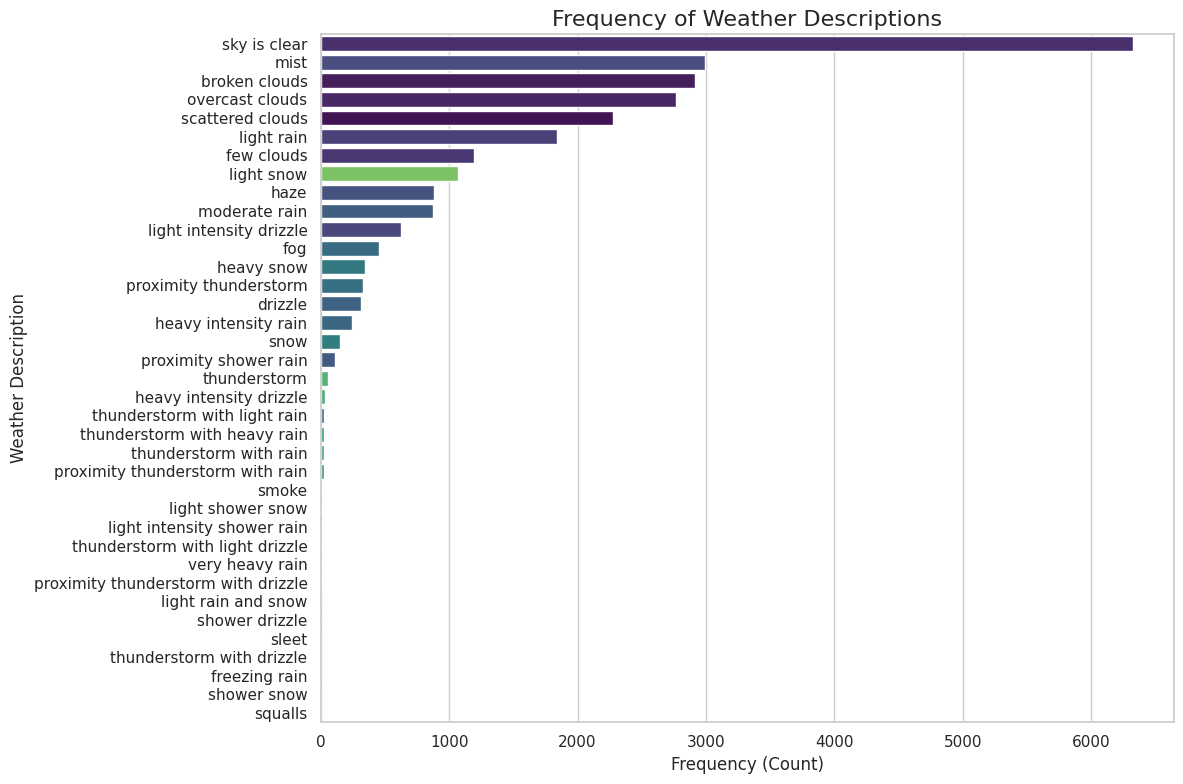

In [24]:
# グラフのサイズとスタイルを設定
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# 2. Seabornのcountplotを使う
sns.countplot(
    data=day_time,
    y="weather_description",
    order=day_time["weather_description"].value_counts().index,
    hue="weather_description",
    palette="viridis",
    legend=False,
)  # 不要な凡例は非表示にする

# タイトルやラベルを追加
plt.title("Frequency of Weather Descriptions", fontsize=16)
plt.xlabel("Frequency (Count)", fontsize=12)
plt.ylabel("Weather Description", fontsize=12)
plt.tight_layout()

plt.show()

結果として、4月から10月にかけての日中データについて、快晴の気象データ以外は、

- shower snow は全て欠損値
- squalls 1つのデータ以外すべて欠損値
- thunderstorm with drizzle 1つのデータ以外すべて欠損値

ということが判明した。

つまり、セル［19］の棒グラフで示された不自然な事象は、標本サイズがアンバランスなデータの影響を受けている可能性が非常に高い。
この場合、当該棒グラフは偏った平均値を反映していることになるため、あのままの状態では参考にならないし、
同セルで立てた私の「暖かい時期でも雷雨やスコールの発生しやすい時期はさけるべきである」という仮説も効力を失う。

上記のような不備が発覚したので、改めて正しいデータを使ったセル［19］の棒グラフの改訂版を作っていく。
新しい棒グラフを作成するにおいて、サンプルサイズが十分に大きく、かつ暖かい時期に発生する気象条件に絞って
トップ10の項目を特定していく。

In [25]:
warm_season_weather_count = day_time[month_condition][
    "weather_description"
].value_counts()
display(warm_season_weather_count)

weather_description
sky is clear                           4080
scattered clouds                       1686
broken clouds                          1625
mist                                   1560
light rain                             1461
overcast clouds                        1319
few clouds                              816
moderate rain                           733
light intensity drizzle                 457
haze                                    313
proximity thunderstorm                  310
heavy intensity rain                    225
fog                                     223
drizzle                                 211
proximity shower rain                   103
light snow                               97
heavy snow                               94
thunderstorm                             53
snow                                     44
heavy intensity drizzle                  29
thunderstorm with light rain             26
thunderstorm with heavy rain             26
thunderstorm

以下の10項目が条件に当てはまる

1. `sky is clear`
2. `scattered clouds`
3. `broken clouds`
4. `mist`
5. `light rain`
6. `overcast clouds`
7. `few clouds`
8. `moderate rain`
9. `light intensity drizzle`
10. `haze`

これより、この10項目について、改めて平均交通量を示す棒グラフを作成する。

In [26]:
print(warm_season_weather_count.index.tolist())

['sky is clear', 'scattered clouds', 'broken clouds', 'mist', 'light rain', 'overcast clouds', 'few clouds', 'moderate rain', 'light intensity drizzle', 'haze', 'proximity thunderstorm', 'heavy intensity rain', 'fog', 'drizzle', 'proximity shower rain', 'light snow', 'heavy snow', 'thunderstorm', 'snow', 'heavy intensity drizzle', 'thunderstorm with light rain', 'thunderstorm with heavy rain', 'thunderstorm with rain', 'proximity thunderstorm with rain', 'smoke', 'light intensity shower rain', 'very heavy rain', 'thunderstorm with light drizzle', 'proximity thunderstorm with drizzle', 'light rain and snow', 'sleet', 'thunderstorm with drizzle', 'squalls', 'shower drizzle']


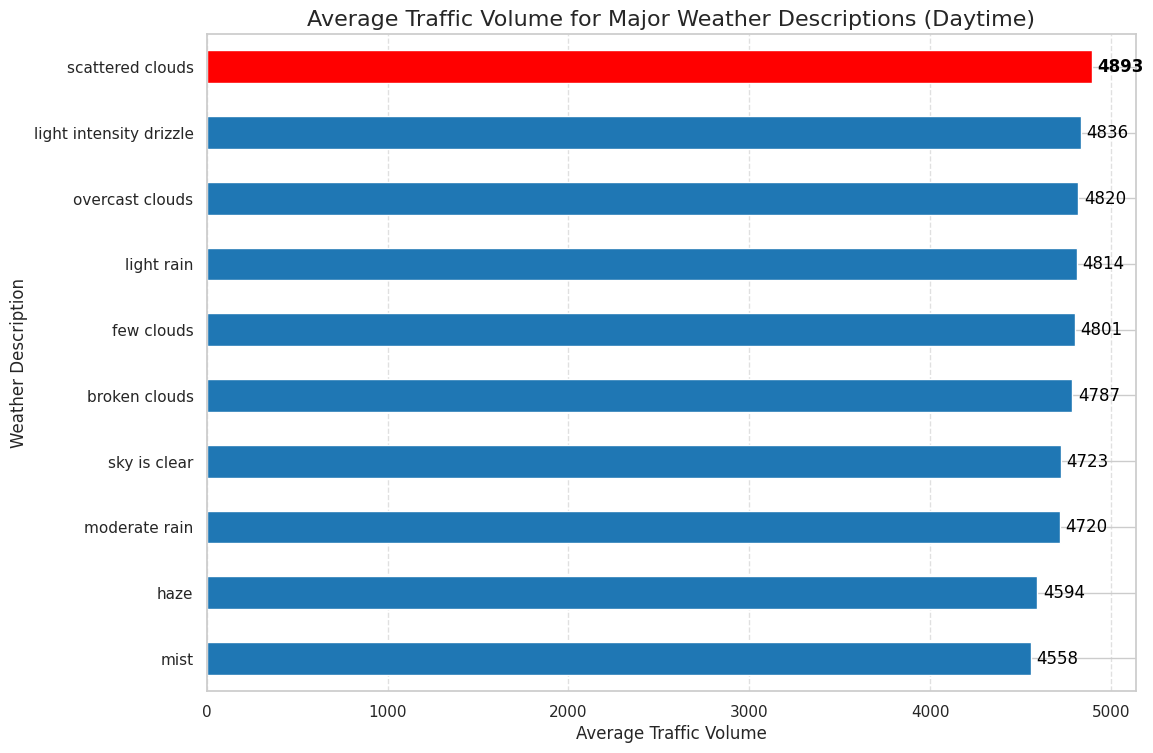

In [27]:
target_weather_list = [
    "sky is clear",
    "mist",
    "broken clouds",
    "overcast clouds",
    "scattered clouds",
    "light rain",
    "few clouds",
    "haze",
    "moderate rain",
    "light intensity drizzle",
]


# 2. 元のデータフレームから、指定した天候のデータだけを抽出する
#    .isin() メソッドが非常に便利です
filtered_day_time = day_time[day_time["weather_description"].isin(target_weather_list)]

# 3. 絞り込んだデータを使って★、天候ごとの平均交通量を計算し、並べ替える
by_weather_description_selected = (
    filtered_day_time.groupby("weather_description")["traffic_volume"]
    .mean()
    .sort_values()  # 昇順（小さい順）に並べ替え
)

# 4. 絞り込んだデータセットの中で、最大の交通量とその天候名を取得
max_volume = by_weather_description_selected.max()
max_weather = by_weather_description_selected.idxmax()


# 5. グラフの描画
plt.figure(figsize=(12, 8))

# 色のリストを作成（指定した天候リストのインデックスに対してループ）
colors = [
    "red" if weather == max_weather else "#1f77b4"
    for weather in by_weather_description_selected.index
]

# 横向き棒グラフを描画
by_weather_description_selected.plot.barh(color=colors)

# 各棒の右側に交通量の数値を表示する
for index, value in enumerate(by_weather_description_selected):
    font_weight = "bold" if value == max_volume else "normal"
    plt.text(
        value + 30,
        index,
        f"{value:.0f}",
        va="center",
        color="black",
        fontweight=font_weight,
    )


plt.title(
    "Average Traffic Volume for Major Weather Descriptions (Daytime)", fontsize=16
)
plt.xlabel("Average Traffic Volume", fontsize=12)
plt.ylabel("Weather Description", fontsize=12)

plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.tight_layout(pad=2.0)
plt.show()

暖かい時期の気象においては、あまり差がないように思えるが、強いて言えば天気が少し悪い日（というより、当該時期における
観測地点の一般的な気象なのかもしれない）の方が交通量が増える傾向があるかのように思える。

おそらく天気が多少悪い時に、雨などに濡れることを気にして普段歩きや自転車・バイクの人たちが車で移動するようになるため、
交通量が増える傾向があるのかもしれない。

ここで気になるのが、最大値をもつ`scattered clouds`と最低値付近のや`mist`との間の差が、統計的に有意かどうかだ。
もし有意であれば、同じ暖かい季節でも、「煙霧」や「霧」といった視界不良を引き起こす気象現象が発生する時期を避けるべきという
重要な指針となる。

よって、これから`rpy2`をつかって`scattered clouds`と`haze`の平均交通量の差が優位かどうか検定を行う。

今回行う検定は、2標本の差の検定である。

サンプルサイズが十分大きいことから正規分布を仮定し、等分散性は必ずしも仮定できないことからいきなりウェルチのt検定を行うこと
もできるが、念のために、「分布の形状」をヒストグラムで可視化し、相互相関と自己相関の有無についても確認する。

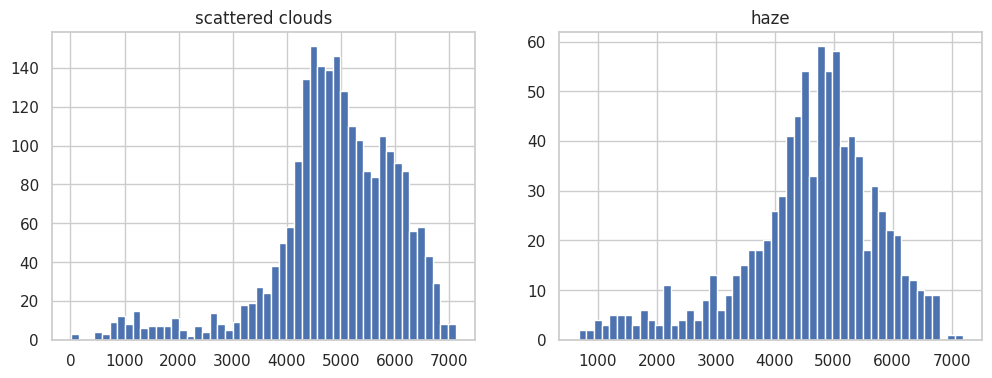

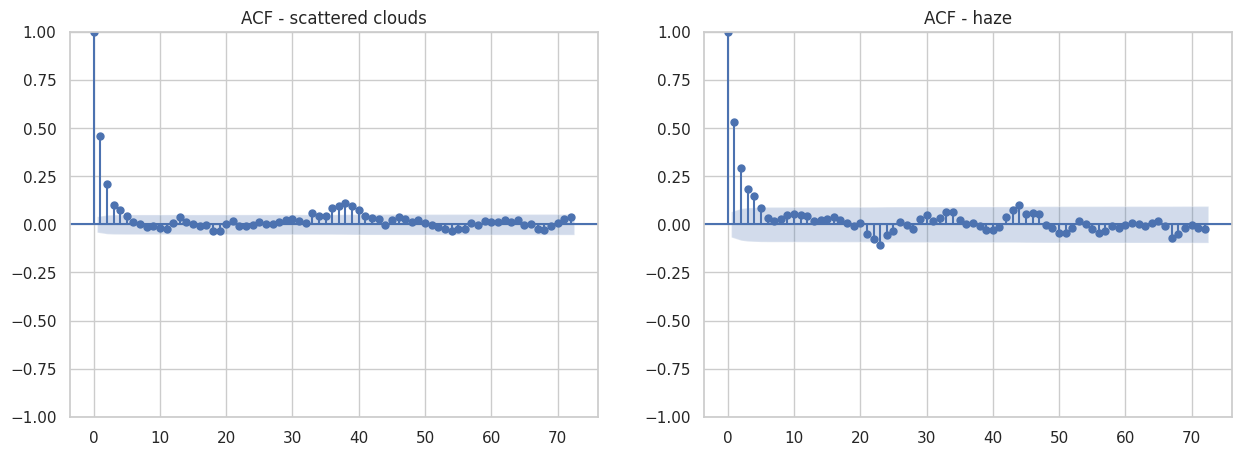

In [28]:
# Series を作る（traffic_volume 列だけ）
sc = day_time.loc[
    day_time["weather_description"] == "scattered clouds", "traffic_volume"
].dropna()
hz = day_time.loc[day_time["weather_description"] == "haze", "traffic_volume"].dropna()

# ヒストグラム
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(sc, bins=50)
plt.title("scattered clouds")
plt.subplot(1, 2, 2)
plt.hist(hz, bins=50)
plt.title("haze")
plt.show()

# ACF（自己相関）
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(sc, lags=72, title="ACF - scattered clouds", ax=axes[0])
plot_acf(hz, lags=72, title="ACF - haze", ax=axes[1])
plt.show()

この結果から、2つの標本に極端な分布の偏りがないこと、自己相関がないことを確認できたので、予定通りウェルチのt検定をおこない、
有意差があるかどうかを検証していく。

In [29]:
# データの抽出（交通量だけを抜き出す）
scattered = day_time.loc[
    day_time["weather_description"] == "scattered clouds", "traffic_volume"
]
haze = day_time.loc[day_time["weather_description"] == "haze", "traffic_volume"]

# Pythonの数値リストをRのベクトルに変換
r_scattered = FloatVector(scattered.tolist())
r_haze = FloatVector(haze.tolist())

# Welchのt検定を実行
t_test = ro.r["t.test"](r_scattered, r_haze)

"""
Rの生出力をそのまま表示したい場合は、以下のコメントアウトを外して実行
print("\n".join(ro.r("capture.output")(t_test)))
"""

# Rの生出力だと出力結果が長くて見栄えが悪いので、必要な情報のみ取捨選択
t_value = float(t_test.rx2("statistic")[0])
df = float(t_test.rx2("parameter")[0])
p_value = float(t_test.rx2("p.value")[0])
conf_interval = list(t_test.rx2("conf.int"))
means = list(t_test.rx2("estimate"))

# 見やすいフォーマットで出力
print("Welch's t-test: scattered clouds vs haze")
print(f" t(df = {df:.1f}) = {t_value:.3f}, p = {p_value:.3g}")
print(f" 95% CI: [{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]")
print(f" mean(scattered clouds) = {means[0]:.2f}")
print(f" mean(haze) = {means[1]:.2f}")

Welch's t-test: scattered clouds vs haze
 t(df = 1588.5) = 6.431, p = 1.67e-10
 95% CI: [207.94, 390.44]
 mean(scattered clouds) = 4893.33
 mean(haze) = 4594.14


上記の結果をまとめると、次のようになる。

$$
\begin{align}
 & H_0:\ \text{scattered clouds と hazeの母平均に差はない} \\
 & H_1:\ \text{scattered clouds と haze の母平均に差がある} \\
 & \text{Test stat: } t = 6.431 \quad (\mathrm{df} = 1588.5) \\
 & \text{p-value: } 1.673 \times 10^{-10} \\
 & \text{Decision: 有意水準 } 5\% (\alpha = 0.05) \text{ で統計的に有意} \\
 & \text{Conclusion: P値が非常に小さいこと、95\%信頼区間が [207.9, 390.4] と} \\
 & \text{\qquad 0 を含まないため、明確な有意差が認められる。}
\end{align}
$$

よって、検定の結果、P値は極めて小さく、2つの天候における平均交通量の差が統計的に有意であることが判明した。
しかし、サンプルサイズが大きいがために自由度も大きく(df=1588.5)、故に検出力が強くなってしまっていることが想像できる。
また、平均値の差は約300台（約6%）に留まっており、これが今回のマーケティング施策において直ちに対策が必要かどうかは
コストとの兼ね合いで判断すべきかと思われる。

これまでの結果を踏まえると、セル［23］の10種類の天候のうち、曇りや小雨のときに比較的交通量が多くなる傾向があり、
視界不良に関連する天候（`haze`や`mist`）が起きやすい日は有意差約6%で平均交通量が少なくなる。

よって、広告効果を最大化するためには、可能であれば

- 交通量が比較的多くなる`scatterd clouds`の時期に集中投下したい
- 交通量が比較的少なくなる`haze`, `mist`の時期を極力避けたい

なので、これから「特定の天候になりやすい時期はあるのか」を調べていく。
まずは、ACFを作成し、各天候の自己相関の度合から周期性が見られるかどうかを確認する。

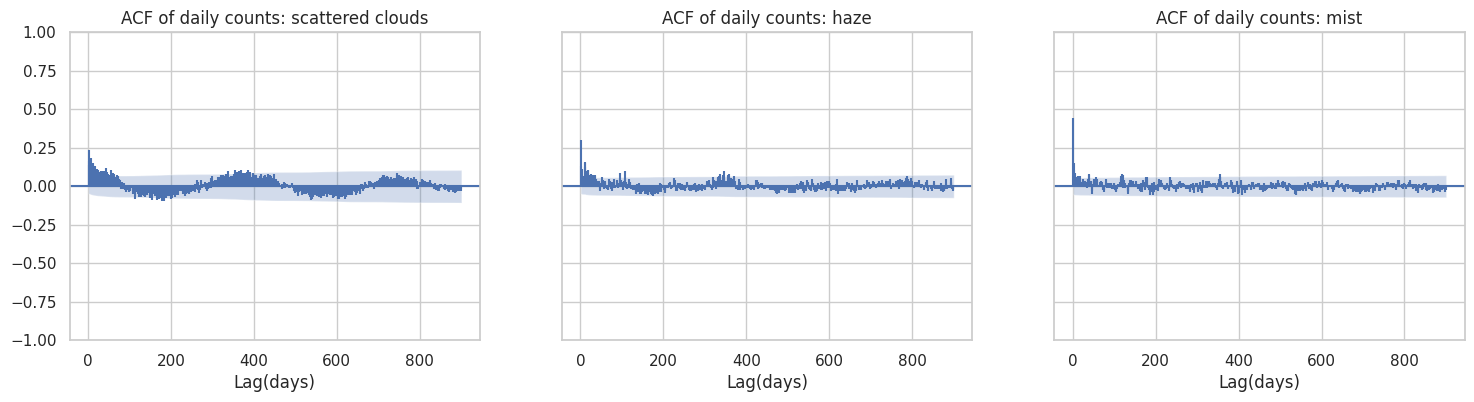

In [30]:
daily_counts = (
    i_94.groupby(["date_only", "weather_description"])
    .size()
    .unstack("weather_description")
    .fillna(0)
)

acf_weathers = ["scattered clouds", "haze", "mist"]
fig, axes = plt.subplots(1, len(acf_weathers), figsize=(18, 4), sharey=True)
lags = 900  # 4~10月の180日× 5で「5年分のサンプル」を確認する

for ax, w in zip(axes, acf_weathers):
    if w not in daily_counts.columns:
        continue
    series = daily_counts[w]
    plot_acf(series, lags=lags, ax=ax, zero=False, marker=None)
    ax.set_title(f"ACF of daily counts: {w}")
    ax.set_xlabel("Lag(days)")

ACFの出力の結果、

- どの天候も、自己相関の度合いが信頼区間の内側に留まっており、この結果からは明確な周期性が存在するとは言えない
- `scattered clouds`は、「天候の持続性」に長期トレンドがあると捉えられる
- `haze`と`mist`は、持続性が`scattered clouds`に比べると低い

という解釈ができそうだ。  
したがって、ACFだけでは周期性の有無を断定できそうにない。  

次に、時間帯$\times $天候のヒートマップで、具体的に「いつその天気になりやすいか」を相対頻度で確認し、周期性の有無を検証する。
これまでの分析結果を踏まると、4~10月の日中（6〜18時）に絞って分析するのが妥当であると考えられる。
よって、まずは暖かい時期の日中に絞ってデータを抽出し、
その中で各天候が観測された回数を月ごと・時間帯ごとに集計し、ヒートマップで可視化する。

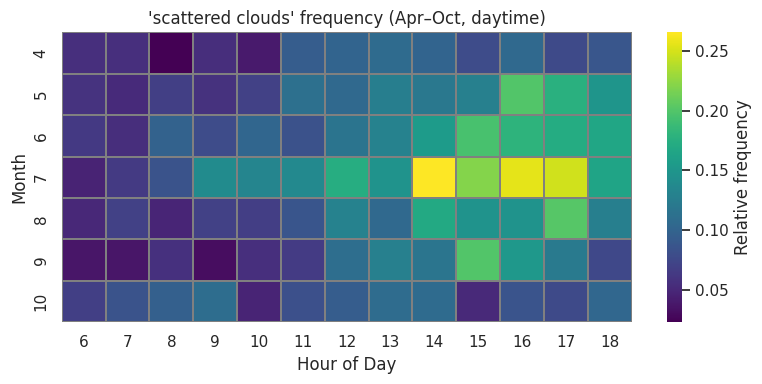

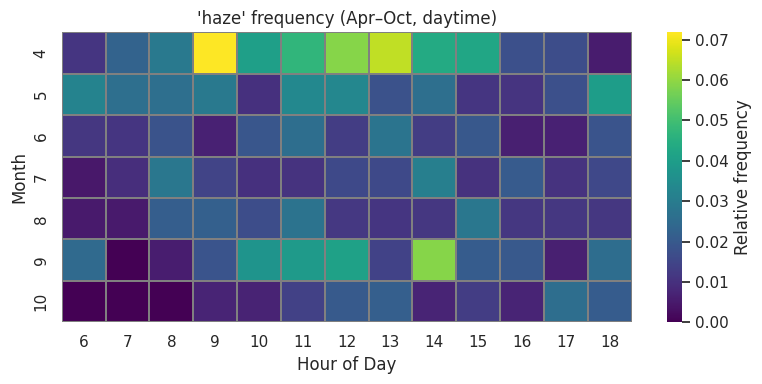

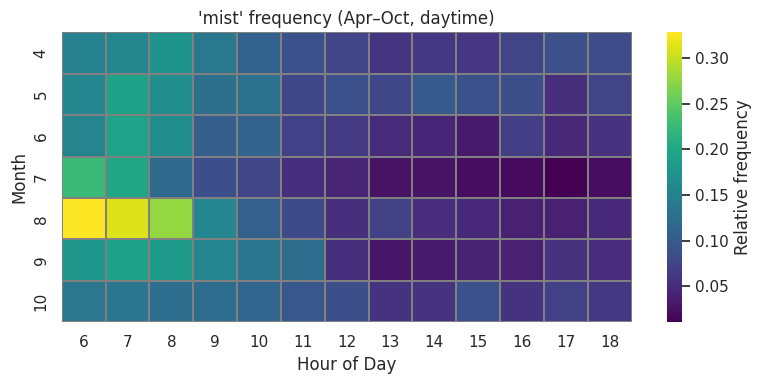

In [31]:
# 暖かい時期 & 日中 （例: 4〜10月 / 6〜18時）に絞ってデータを抽出
warm_daytime = i_94[
    (i_94["date_time"].dt.month.between(4, 10))
    & (i_94["date_time"].dt.hour.between(6, 18))
].copy()

warm_daytime["month"] = warm_daytime["date_time"].dt.month
warm_daytime["hour"] = warm_daytime["date_time"].dt.hour

target_weathers = ["scattered clouds", "haze", "mist"]


def plot_weather_heatmap(weather, normalize=True):
    df = warm_daytime[warm_daytime["weather_description"] == weather].copy()

    # その天気が観測された回数
    counts = (
        df.groupby(["month", "hour"])
        .size()
        .unstack("hour")
        .reindex(index=range(4, 11), columns=range(6, 19))
        .fillna(0)
    )

    if normalize:
        # ベース：全天気での観測回数
        base = (
            warm_daytime.groupby(["month", "hour"])
            .size()
            .unstack("hour")
            .reindex(index=range(4, 11), columns=range(6, 19))
            .fillna(0)
        )
        data = counts / base.replace(0, np.nan)
        cbar_label = "Relative frequency"
    else:
        data = counts
        cbar_label = "Count"

    plt.figure(figsize=(8, 4))
    sns.heatmap(
        data,
        cmap="viridis",
        linewidths=0.2,
        linecolor="gray",
        cbar_kws={"label": cbar_label},
    )
    plt.title(f"'{weather}' frequency (Apr–Oct, daytime)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Month")
    plt.tight_layout()
    plt.show()


for w in target_weathers:
    plot_weather_heatmap(w, normalize=True)

結果として、以下のことがわかった。

- `scattered clouds`は、５～8月の夕方にかけて発生頻度が高く、特に7月の14〜17時台にピークがある
- `haze`は明確なトレンドはないが、4月の昼頃に発生頻度がやや高い
- `mist`は時期を問わず朝に発生頻度が高く、昼以降は減少する傾向がある。8月の6〜8時台にピークがある

いずれの天候も相対頻度のスケールが低く、明確な周期性は見られないが、
`scattered clouds`の発生頻度の分析の結果は、これまでの「時間的要因と交通量の分析」で示された洞察と整合的であり、
「暖かい季節の夕方に交通量が多くなる」という傾向を補強するものとなった。しかし、


`scattered cloud`が発生しやすい時期と、`haze`及び`mist`が発生しやすい時期が被っていないことから、今回のマーケティング施策は
これまでの分析でも示された通り、夏の夕方に集中投下するのが最も効果的であると考えられる。

<hr>
【補足】
この傾向が統計的に有意かどうかを検証するために、天候と時間帯の独立性をカイ二乗検定で調べることもできるが、
サンプルサイズが大きいことから検出力が高くなりやすいことと、ヒートマップからおおよその相対頻度を確認できることから、
ここではあえてカイ二乗検定は行わないこととする。

#### 最終確認

最後に、日中データ全体における月別の交通量統計量を確認し、
これまでの分析で示された「暖かい季節に交通量が多くなる」という洞察が全体データにおいても成り立つかどうかを確認する。

これまでの分析では、「最も交通量が多くなると期待できる条件」を明らかにすることを目的としていたため、平均値について
のみ注目していた。その結果、4〜10月（特に４月、10月）に交通量が多くなるという洞察が得られたわけだが、これが果たして、
中央値についても同じような傾向が見られるのかどうかを確認する。

中央値は、外れ値の影響を受けにくい指標であるため、もし中央値についても同様の傾向が見られれば、
「暖かい季節に交通量が多くなる」という洞察がより強固なものとなるだけでなく、ビルボードの広告効果を最大化するための
戦略立案においても有用な情報となる。

よって、これから日中データ全体における月別の交通量の平均値と中央値を計算し、比較していく。
この分析の目的は、最終確認として保守的な視点からこれまでの洞察を検証することであるため、
99パーセンタイルでトリミングした場合の結果も同時に示すこととする。

In [32]:
daytime_clean = day_time.dropna(subset=["traffic_volume"]).copy()
stats_raw_full = daytime_clean.groupby("month")["traffic_volume"].agg(
    count="size", mean="mean", median="median"
)
# 上位1%を外してトリミング（全日中の99パーセンタイルを閾にする）
p99_full = daytime_clean["traffic_volume"].quantile(0.99)
day_trim_full = daytime_clean[daytime_clean["traffic_volume"] <= p99_full].copy()
# トリミング後の月別集計
stats_trim_full = day_trim_full.groupby("month")["traffic_volume"].agg(
    count="size", mean="mean", median="median"
)
# 比較用に結合（列名に接頭辞を付ける）
compare_full = stats_raw_full.add_prefix("raw_").join(
    stats_trim_full.add_prefix("trim_")
)
# 表示（trim_median の降順で並べ替えて表示）
display(compare_full.sort_values("trim_median", ascending=False))

,raw_count,raw_mean,raw_median,trim_count,trim_mean,trim_median
month,,,,,,
10,1888,4885.176377,4982.0,1877,4873.101225,4980.0
4,2252,4855.753996,5007.5,2186,4791.957914,4978.5
8,2363,4880.405840,4971.0,2351,4870.171842,4968.0
5,2398,4864.847373,4968.5,2351,4823.884730,4943.0
6,2065,4844.947215,4947.0,2048,4828.013672,4938.0
3,2016,4808.595238,4946.5,1987,4777.859084,4935.0
9,2026,4822.254195,4864.0,2020,4815.925743,4859.5
2,1881,4668.720893,4793.0,1861,4644.095110,4786.0
11,1977,4655.133030,4762.0,1950,4623.339487,4747.0


上記の結果と、これまでの分析結果を比較すると、

- セル［10］で示された平均値の分析では、
 1. 4月
 2. 10月
 3. 次点で5月６月８月が続く

という順番で交通量が多いことがわかったが、

- 今回の中央値の分析では、
 1. 10月
 2. 4月
 3. 次点で8月６月５月が続く

という順番で交通量が多いことがわかった。

従って、中央値に基づく分析でも、暖かい季節（4〜10月）に交通量が多くなる傾向が確認できた。
こうなると、4〜10月をターゲットにすることは前提となるだろう。そのうえで、何月に施策の予算を多く割り当てるかは、
保守的な姿勢（中央値ベース）ととるか、積極的な姿勢（期待値ベース）ととるかによって変わってくるため、
マーケティング部門の方針次第となるだろう。

## まとめ

本プロジェクトでは、I‑94州間高速道路（西行き）の交通量データを用いて、
デジタルビルボードの広告効果を高めるために、

- 「どのような時間帯・曜日・季節に交通量が多くなるのか」
- 「どのような気象条件のときに交通量が増えたり減ったりするのか」

を探索的データ分析（EDA）によって調べた。

### 1. 時間的要因から見えたこと

- **季節**  
  - 日中データに限定した分析では、**4〜10月の暖かい季節に交通量が多く、冬季に減少する**周期性が確認できた。
- **曜日**  
  - 週末よりも平日の交通量が多く、**平日の中では、特に木・水・金の順に交通量が多い**傾向がある。
- **時間帯**  
  - 平日に限ると、**朝6〜8時台と夕方15時代～17時台にラッシュアワーがあり、特に16時頃が最大**となる。

また、時間軸の分析の途中で、

- 2016年7月の一部期間で交通量が大きく落ち込む
- 2014年8月7日〜2015年6月12日にかけて交通量がほぼ変動しない

といった「不自然な推移」を発見したが、  
どちらもデータの異常や欠損の可能性が高いことを確認した。


### 2. 気象条件から見えたこと

- 量的変数としての `temp`（ケルビン温度）は、`traffic_volume` との相関が弱く、**気温だけから交通量変動を説明するのは難しい**
 ことがわかった。

- カテゴリ変数としての `weather_main` / `weather_description` を用いた分析では、
 快晴よりも、**曇りや小雨、霧なども含めた「やや悪天候」のときに交通量が多い**傾向 が見られた。

- 一方で、`haze` や `mist` など**視界不良となる天候では平均交通量が比較的低い**

これらの結果から、ミネソタ州の湿潤大陸性気候により、雲がかかってくると現地住民は雨を警戒して移動手段を車にするかもしれない
こと、冬季の交通量が減少する原因についても、同様に冬場の厳しい気象に起因するものかもしれないという考察を行った。

また、暖かい季節（4〜10月）の日中データに絞り、  
十分な標本サイズをもつ主要な気象条件10種類に限定して再集計したところ、

- 全体としてはそこまで極端な差はないものの、**scattered clouds のときに最も交通量が多く、hazeやfog のときにやや少ない**

というパターンが棒グラフの頻度分析により視認できた。

このパターンの統計的有意性を検証するため、`scattered clouds` と `haze` の日中交通量について、R（rpy2）による
Welch の t 検定を行った結果、

- P値が$ 1.673 \times  10^{-10} $と十分に小さい
- 母平均の差の95%信頼区間が約 208〜390 台／時（約 4〜8%差）

であることから、**統計的には有意な差がある**と判断した。

ただし、標本サイズ・自由度が高いため、検出力が高くなってしまった可能性を考慮すべきであり、
**実務上どこまで重要な差とみなすかは、広告コストとのバランスを見ながら判断すべき**である。


また、`scattered clouds`・`haze`・`mist`の3つの天候について、ACFとヒートマップを用いて周期性の有無を調査した結果、
いずれの天候も明確な周期性は見られなかったが、

- `scattered clouds`は5〜8月の夕方にかけて発生頻度が高く、特に**7月の14〜17時台にピークがある**
- `haze`は4月の昼頃に発生頻度がやや高い
- `mist`は時期を問わず朝に発生頻度が高く、昼以降は減少する傾向がある。8月の6〜8時台にピークがある

という傾向が見られた。

特に、`scattered clouds`の発生頻度の分析の結果は、これまでの「時間的要因と交通量の分析」で示された洞察と整合的であり、
「暖かい季節の夕方に交通量が多くなる」という傾向を補強するものとなった。

---

### 3. 広告戦略の観点での示唆

広告配信設計としては、「4〜10月の暖かい季節」に出稿することが最優先事項となる。ミネソタ州の厳しい冬季を避けるためである。

また、以下の点を考慮することで、広告効果を最大化できると考えられる。
1. 「週末よりも平日に重点的に配信する」
2. 「平日の中でも特に木・水・金に重点的に配信する」
3. 「1日の中でも特に夕方15〜18時台に集中的に配信する」

そのうえで、予算とスケジュールに余裕がある場合は、
「曇りや小雨のときに配信を強化し、視界不良となる天候（haze, mist）のときは配信を控える」など、天候APIを活用した戦略も
検討の余地がある。